This demo is derived from this [article](https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948)

This demo will show you how to build a bidirectional LSTM for text classification in just a few minutes.
The demo is divided into the following steps:

1. Load in and visualize the data
2. Data processing
3. Training, Validation, Test Dataset Split
4. Define the LSTM Network Architecture
5. Training the Network
6. Testing

# Preprocess data
Data used in this demo is from [IMDB review dataset](http://ai.stanford.edu/~amaas/data/sentiment/).  
First, download the dataset and preprocess it.

## Download data and read

In [1]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2021-07-19 03:30:00--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  29.1MB/s    in 2.8s    

2021-07-19 03:30:03 (29.1 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [2]:
# upzip downloaded file
!tar -xf aclImdb_v1.tar.gz
!mv ./aclImdb ./data

In [3]:
# load data
import os
train_reviews = []
train_labels = []
test_reviews = []
test_labels = []

path = './data/train/pos/'
for file in os.listdir(path):
    with open(path + file) as f:
        review = f.read()
        train_reviews.append(review)
        train_labels.append(1) # 1 mean positive

path = './data/train/neg/'
for file in os.listdir(path):
    with open(path + file) as f:
        review = f.read()
        train_reviews.append(review)
        train_labels.append(0) # 0 mean negative

path = './data/test/pos/'
for file in os.listdir(path):
    with open(path + file) as f:
        review = f.read()
        test_reviews.append(review)
        test_labels.append(1) # 1 mean positive

path = './data/test/neg/'
for file in os.listdir(path):
    with open(path + file) as f:
        review = f.read()
        test_reviews.append(review)
        test_labels.append(0) # 0 mean negative

print('train data length', len(train_reviews))
print('test data length', len(test_reviews))

train data length 25000
test data length 25000


In [4]:
print(train_reviews[0])
print(train_labels[0])

Erich Rohmer's "L'Anglaise et le duc" makes a perfect companion piece to Peter Watkins' "La Commune (Paris 1871)." Both films -screened at this year's Toronto International Film Festival- ironically illustrate how history is shaped to by the tellers of the tale. Ironic, given the tragic events that were taking place in the U.S. during the festival.<br /><br />Set in Paris during the French Revolution, the movie, based on Grace Elliott's (Lucy Russell) "Memoirs," is a first-hand account of how she survived those heady but dangerous days. She also details her relationship with The Duke of Orleans (played by Jean-Claude Dreyfus), who, in contrast to herself, is a supporter of the Revolution.<br /><br />True to form, you don't know whose side of history Rohmer is going to come down on. One of the earliest of the French "New Wave" filmmakers, Rohmer has often been criticized for being too conservative. After all, in the midst of the rebelling-youth-Viet-Nam days of the late 60s and 70s, he 

## Convert to lower case and remove punctuation

In [5]:
from string import punctuation
def preprocess(text):
    # convert to lower case
    text = text.lower()

    # remove punctuation 
    # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
    text = ''.join([c for c in text if c not in punctuation])

    return text

train_reviews = [preprocess(r) for r in train_reviews]
test_reviews = [preprocess(r) for r in test_reviews]

# Tokenize and create vocabulary-to-integer mapping dictionary
In most of the NLP tasks, you will create an index mapping dictionary in such a way that your frequently occurring words are assigned lower indexes. One of the most common way of doing this is to use `Counter` method from `Collections` library.

In [6]:
from collections import Counter
def build_vocab(train, test):

    counter = Counter()
    for review in train:
        words = review.split()
        counter.update(words)

    for review in test:
        words = review.split()
        counter.update(words)

    print('dictionary length', len(counter.items()))
    # trick here, 
    # we count the first word from 1 to preserve 0 for padding token
    vocab = {w:i+1 for i, (w,c) in enumerate(counter.items())}
    # vocab['<pad>'] = 0
    return vocab

vocab = build_vocab(train_reviews, test_reviews)

dictionary length 181685


## Convert reviews into vector
Reviews are currently in type of text. Before passing them to model, we have to convert them into vectors of numbers using `vocab`

In [7]:
# Convert reviews into vectors
def numericalize(reviews, vocab):
    vectors = []
    for review in reviews:
        vector = [vocab[w] for w in review.split()]
        vectors.append(vector)
    return vectors

train_vectors = numericalize(train_reviews, vocab)
test_vectors = numericalize(test_reviews, vocab)

## Pad and truncate data

In [8]:
train_vectors_length = [len(v) for v in train_vectors]
test_vectors_length = [len(v) for v in test_vectors]

min review length 10
max review length 2469
mean review length 232.87256


[]

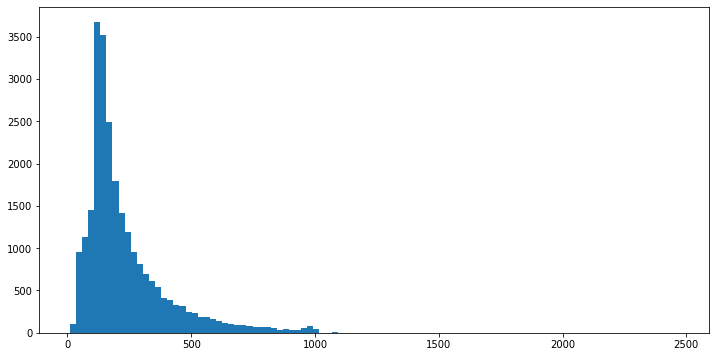

In [9]:
import matplotlib.pyplot as plt
print('min review length', min(train_vectors_length))
print('max review length', max(train_vectors_length))
print('mean review length', sum(train_vectors_length) / len(train_vectors_length))

plt.figure(figsize=(12,6))
plt.hist(train_vectors_length, bins=100)
plt.plot()

As the histogram depict, there are approximate 80% of data has fewer than 500 words. We will choose this as the fixed-length of data. Review with shorter length will be padded; review with longer length will be truncated to the fixed-length. 

In [10]:
def edit_length(vectors):
    fixed_length = 500
    pad_index = 0
    new_vectors = []
    for vector in vectors:
        if len(vector) < fixed_length:
            # add padding index to head of vector
            vector = [pad_index] * (fixed_length - len(vector)) + vector
        else:
            vector = vector[:fixed_length]
        new_vectors.append(vector)
        
    return new_vectors

train_vectors = edit_length(train_vectors)
test_vectors = edit_length(test_vectors)

# Train, dev split

In [11]:
from sklearn.model_selection import train_test_split
train_vectors, valid_vectors, train_labels, valid_labels = \
    train_test_split(train_vectors, train_labels, test_size=0.2, random_state=0)

In [12]:
print(len(train_vectors), len(valid_vectors))
print(len(train_labels), len(valid_labels))

20000 5000
20000 5000


In [13]:
from torch.utils.data import TensorDataset, DataLoader
import torch
train_ds = TensorDataset(torch.Tensor(train_vectors),
                        #  torch.LongTensor(train_vectors_length),
                    torch.Tensor(train_labels))
valid_ds = TensorDataset(torch.Tensor(valid_vectors),
                        #  torch.LongTensor(train_vectors_length),
                    torch.Tensor(valid_labels))
test_ds = TensorDataset(torch.Tensor(test_vectors), 
                        # torch.LongTensor(test_vectors_length),
                        torch.Tensor(test_labels))

batch_size = 64
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, 
                      drop_last=True)
valid_dl = DataLoader(valid_ds, shuffle=False, batch_size=batch_size)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=batch_size)

# Define LSTM architechture

In [20]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, 
                 hidden_dim, n_layers, 
                 drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (torch.cuda.is_available()):
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
            cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
        else:
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
            cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        
        return hidden, cell

# Train model

In [21]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 300
hidden_dim = 300
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(181686, 300, padding_idx=0)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [33]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 4 # 

counter = 0
print_every = 1
clip=5 # gradient clipping
train_on_gpu = torch.cuda.is_available()

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h, c = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_dl:
        counter += 1

        inputs = inputs.long()
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = h.data
        c = c.data

        if train_on_gpu:
            h = h.cuda()
            c = c.cuda()

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        
        output, (h, c) = net(inputs, (h, c))

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_dl:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                inputs = inputs.long()
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()
                
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

RuntimeError: ignored

# Test

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))